In [1]:
import os
import pandas as pd
import librosa
from pathlib import Path
from tqdm import tqdm

In [2]:
# torchaudio가 헤더만 읽어 duration 계산해서 빠름 (전체 파형 디코딩 X)
import torchaudio

In [3]:
# === 루트 경로 (정정하신 절대경로) ===
ROOT = Path(r"D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감정분류대화음성\감정 분류를 위한 대화 음성 데이터셋")
PARTS = ["4차", "5차", "5_2차"]  # 하위 폴더명

In [4]:
def try_read_csv(csv_path: Path) -> pd.DataFrame:
    """구분자/인코딩 자동 감지 시도."""
    # sep=None + engine='python' -> 구분자 추정
    encodings = ["utf-8-sig", "cp949", "euc-kr"]
    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(csv_path, sep=None, engine="python", encoding=enc)
        except Exception as e:
            last_err = e
    raise last_err

In [5]:
def get_duration_fast(wav_path: Path):
    """torchaudio.info로 빠르게 재생시간(초) 계산. 실패 시 None."""
    try:
        info = torchaudio.info(str(wav_path))
        # num_frames / sample_rate = seconds
        return float(info.num_frames) / float(info.sample_rate)
    except Exception:
        return None

In [6]:
def load_one_part(part_name: str) -> pd.DataFrame:
    """한 파트(예: 4차) CSV 로드 → wav 절대경로 붙이고 duration 계산."""
    part_dir = ROOT / part_name

    # CSV 파일 찾기 (파일명이 정해져 있지 않을 수 있으므로 *.csv 1개 선택)
    csv_candidates = list(part_dir.glob("*.csv"))
    if not csv_candidates:
        raise FileNotFoundError(f"[{part_name}] CSV를 찾을 수 없습니다: {part_dir}")
    csv_path = csv_candidates[0]  # 필요하면 규칙에 맞춰 선택 로직 추가

    df = try_read_csv(csv_path)

    # 필수 컬럼 확인
    if "wav_id" not in df.columns:
        raise KeyError(f"[{part_name}] CSV에 'wav_id' 컬럼이 없습니다. 실제 컬럼들: {list(df.columns)}")

    # 절대경로 생성
    df["wav_path"] = df["wav_id"].astype(str).apply(lambda x: str(part_dir / f"{x}.wav"))

    # 파일 존재 여부/유실 체크
    df["wav_exists"] = df["wav_path"].apply(lambda p: os.path.exists(p))

    # duration 계산 (존재하는 파일만)
    durations = []
    for p in tqdm(df["wav_path"], desc=f"duration: {part_name}"):
        durations.append(get_duration_fast(Path(p)))
    df["duration"] = durations

    df["dataset_part"] = part_name
    return df

In [7]:
# === 전체 병합 ===
dfs = [load_one_part(p) for p in PARTS]
full_df = pd.concat(dfs, ignore_index=True)

duration: 5_2차: 100%|██████████| 19374/19374 [00:25<00:00, 762.24it/s]


In [8]:
# 간단 무결성 로그
missing = (~full_df["wav_exists"]).sum()
print(f"총 {len(full_df):,}행 / 오디오 없음 {missing:,}행")

총 43,991행 / 오디오 없음 16행


In [9]:
full_df.columns

Index(['wav_id', '발화문', '상황', '1번 감정', '1번 감정세기', '2번 감정', '2번 감정세기', '3번 감정',
       '3번 감정세기', '4번 감정', '4번감정세기', '5번 감정', '5번 감정세기', '나이', '성별',
       'wav_path', 'wav_exists', 'duration', 'dataset_part'],
      dtype='object')

In [10]:
# 교정 대상: '4번감정세기' → '4번 감정세기'
full_df = full_df.rename(columns={"4번감정세기": "4번 감정세기"})

In [11]:
full_df.columns

Index(['wav_id', '발화문', '상황', '1번 감정', '1번 감정세기', '2번 감정', '2번 감정세기', '3번 감정',
       '3번 감정세기', '4번 감정', '4번 감정세기', '5번 감정', '5번 감정세기', '나이', '성별',
       'wav_path', 'wav_exists', 'duration', 'dataset_part'],
      dtype='object')

In [12]:
label_map = {
    "Sadness": "sad",
    "Angry": "angry",
    "Disgust": "disgust",
    "Fear": "fear",
    "Neutral": "neutral",
    "Happiness": "happiness",
    "Surprise": "surprise",
    # 소문자로 들어온 것도 맞춤
    "sad": "sad", "anger": "angry", "disgust": "disgust", "fear": "fear",
    "neutral": "neutral", "happiness": "happiness", "surprise": "surprise",

    "sadness": "sad",
    "anger": "angry",
    "angry": "angry",
    "disgust": "disgust",
    "fear": "fear",
    "neutral": "neutral",
    "happiness": "happiness",
    "surprise": "surprise"
}

# annotator 5명 감정 모두 표준화
for i in range(1, 6):
    col = f"{i}번 감정"
    full_df[col] = full_df[col].map(label_map)
# df['final_emotion'] = df['final_emotion'].map(label_map).fillna(df['final_emotion'])
full_df['상황'] = full_df['상황'].map(label_map).fillna(full_df['상황'])

In [13]:
full_df.columns

Index(['wav_id', '발화문', '상황', '1번 감정', '1번 감정세기', '2번 감정', '2번 감정세기', '3번 감정',
       '3번 감정세기', '4번 감정', '4번 감정세기', '5번 감정', '5번 감정세기', '나이', '성별',
       'wav_path', 'wav_exists', 'duration', 'dataset_part'],
      dtype='object')

In [14]:
full_df.iloc[:,2:13].value_counts()

상황        1번 감정     1번 감정세기  2번 감정     2번 감정세기  3번 감정     3번 감정세기  4번 감정     4번 감정세기  5번 감정     5번 감정세기
sad       sad       1        sad       1        sad       1        sad       1        sad       1          936
                                       2        sad       1        sad       1        sad       1          820
          neutral   0        sad       1        sad       1        sad       1        sad       1          611
          sad       1        sad       1        sad       1        sad       1        sad       2          449
                    2        sad       1        sad       1        sad       1        sad       1          439
                                                                                                          ... 
disgust   sad       1        neutral   0        neutral   0        angry     1        angry     1            1
                                                fear      1        neutral   0        neutral   0            1
        

In [15]:
full_df['5번 감정']

0          angry
1          angry
2          angry
3            sad
4            sad
          ...   
43986        sad
43987    neutral
43988        sad
43989        sad
43990    neutral
Name: 5번 감정, Length: 43991, dtype: object

In [16]:
from collections import Counter
import pandas as pd

def majority_vote_with_tie(row):
    # annotator 라벨 5개 모으기
    labels = [row[f"{i}번 감정"] for i in range(1, 6)]
    labels = [l for l in labels if pd.notna(l)]
    if not labels:
        return None
    
    cnt = Counter(labels)
    most_common = cnt.most_common()
    
    # 최빈값 후보들
    top_count = most_common[0][1]
    candidates = [lab for lab, n in most_common if n == top_count]
    
    if len(candidates) == 1:
        return candidates[0]
    else:
        # 동률인 경우 → placeholder
        return "TIE"

full_df["final_emotion"] = full_df.apply(majority_vote_with_tie, axis=1)

# 동률 건수 확인
print("동률 발생 건수:", (full_df["final_emotion"] == "TIE").sum())


동률 발생 건수: 4788


In [17]:
from collections import Counter
import pandas as pd

def vote_with_situation(row):
    """
    return: (final_emotion, tie_initial(bool), tie_resolved_by_situation(bool))
    - tie_initial: 어노테이터 5표만으로 동률이었는지
    - tie_resolved_by_situation: 상황 1표를 추가했더니 해소되었는지
    """
    # 1) 어노테이터 표 수집
    labels = [row.get(f"{i}번 감정") for i in range(1, 6)]
    labels = [l for l in labels if pd.notna(l)]

    if not labels:
        return (None, False, False)

    cnt = Counter(labels)
    mc = cnt.most_common()
    top = mc[0][1]
    top_cands = [lab for lab, n in mc if n == top]

    # 2) 최초 투표에서 단일 최다 득표자면 종료
    if len(top_cands) == 1:
        return (top_cands[0], False, False)

    # 3) 동률이면 상황 1표 추가 후 재투표
    situation = row.get("상황")
    tie_initial = True
    if pd.notna(situation):
        cnt_with_sit = Counter(labels + [situation])
        mc2 = cnt_with_sit.most_common()
        top2 = mc2[0][1]
        top2_cands = [lab for lab, n in mc2 if n == top2]
        if len(top2_cands) == 1:
            return (top2_cands[0], True, True)

    # 4) 여전히 동률이면 TIE로 남김
    return ("TIE", tie_initial, False)

# 적용
full_df[["final_emotion", "tie_initial", "tie_resolved_by_situation"]] = (
    full_df.apply(vote_with_situation, axis=1, result_type="expand")
)


In [19]:
full_df[full_df['final_emotion']=="TIE"]

,wav_id,발화문,상황,1번 감정,1번 감정세기,2번 감정,2번 감정세기,3번 감정,3번 감정세기,4번 감정,...,5번 감정세기,나이,성별,wav_path,wav_exists,duration,dataset_part,final_emotion,tie_initial,tie_resolved_by_situation
57,5e29919c5807b852d9e01a66,어제 지진 난 거 알아?,fear,surprise,1,surprise,1,fear,1,neutral,...,0,29,male,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,1.749333,4차,TIE,True,False
134,5e2aeded5807b852d9e021d0,"하, 얼른 잊어버려야지.",disgust,angry,1,angry,1,disgust,1,neutral,...,0,29,female,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,2.645333,4차,TIE,True,False
183,5e2d20d65807b852d9e0250b,당연히 완전 놀랐지.,disgust,disgust,1,angry,2,angry,1,surprise,...,1,32,female,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,2.176000,4차,TIE,True,False
288,5e2d912b5807b852d9e02674,"아니, 한달 전에 주의 한 번만 해봤어.",angry,angry,1,sad,1,neutral,0,neutral,...,1,30,female,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,4.138667,4차,TIE,True,False
306,5e2d96d65807b852d9e026cc,다 포기 했어. 어쩌지?,angry,angry,1,sad,1,sad,1,neutral,...,0,30,female,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,3.797333,4차,TIE,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43911,5fbe2402cb503578af9eecd6,진짜 너가 다 돈 줄 거야?,happiness,neutral,0,angry,1,surprise,2,neutral,...,1,24,female,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,2.944000,5_2차,TIE,True,False
43914,5fbe249d576e9378b67ad3df,"아니, 계속 집에만 있어야하잖아.",sad,disgust,1,disgust,1,sad,2,angry,...,1,24,female,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,5.461333,5_2차,TIE,True,False
43956,5fbe33d0576e9378b67ad4c9,오늘 마라톤 대회를 나갔는데 기록을 갱신했어!,happiness,neutral,0,happiness,1,neutral,0,sad,...,1,23,female,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,5.632000,5_2차,TIE,True,False
43965,5fbe2db6cb503578af9eed5e,와 짜장면에서 벌레나왔어.,disgust,sad,1,sad,1,disgust,2,neutral,...,0,23,female,D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...,True,3.797333,5_2차,TIE,True,False


In [20]:
# 건수 요약
n_initial_ties = int(full_df["tie_initial"].sum())
n_resolved     = int(full_df["tie_resolved_by_situation"].sum())
n_remaining    = int((full_df["final_emotion"] == "TIE").sum())
n_total        = len(full_df)

print(f"총 샘플: {n_total:,}")
print(f"- 최초 동률: {n_initial_ties:,}")
print(f"- 상황 투표로 해소: {n_resolved:,}")
print(f"- 여전히 동률(TIE): {n_remaining:,}")

# 최종 라벨 분포 (TIE 포함)
print("\n[final_emotion 분포]")
print(full_df["final_emotion"].value_counts(dropna=False))

# (옵션) 상황 투표로 해소된 행만의 상황 vs 최종 교차표
resolved_mask = full_df["tie_resolved_by_situation"] == True
if resolved_mask.any():
    print("\n[상황 투표로 해소된 케이스: 상황 vs final_emotion]")
    print(pd.crosstab(full_df.loc[resolved_mask, "상황"],
                      full_df.loc[resolved_mask, "final_emotion"]))

# (옵션) 아직 TIE인 샘플 몇 개 보기
print("\n[TIE 샘플 예시 5개]")
print(full_df.loc[full_df["final_emotion"] == "TIE",
                  ["wav_id", "상황"] + [f"{i}번 감정" for i in range(1,6)]].head())


총 샘플: 43,991
- 최초 동률: 4,788
- 상황 투표로 해소: 3,221
- 여전히 동률(TIE): 1,567

[final_emotion 분포]
final_emotion
sad          16577
angry         8154
neutral       6891
happiness     3953
fear          2986
disgust       2715
TIE           1567
surprise      1148
Name: count, dtype: int64

[상황 투표로 해소된 케이스: 상황 vs final_emotion]
final_emotion  angry  disgust  fear  happiness  neutral  sad  surprise
상황                                                                    
angry            819        0     0          0        0    0         0
disgust            0      376     0          0        0    0         0
fear               0        0   398          0        0    0         0
happiness          0        0     0        352        0    0         0
neutral            0        0     0          0      627    0         0
sad                0        0     0          0        0  404         0
surprise           0        0     0          0        0    0       245

[TIE 샘플 예시 5개]
                       wav

In [21]:
full_df['상황'].value_counts()

상황
sad          14000
angry        11635
disgust       4660
happiness     4548
fear          4131
neutral       3262
surprise      1755
Name: count, dtype: int64

In [18]:
clean_df = full_df[full_df["final_emotion"] != "TIE"].copy()

In [19]:
clean_df["utter_len"] = clean_df["발화문"].astype(str).apply(len)

In [20]:
from collections import Counter
import pandas as pd
import re

def ensure_agreement_ratio(df: pd.DataFrame,
                           final_col: str = "final_emotion",
                           k: int = 5) -> pd.DataFrame:
    """
    df에 agreement 관련 컬럼이 없으면 생성해서 반환.
    - agreement_ratio = 최다 득표수 / 유효표수
    - agreement_count = 최다 득표수
    - voters_count = 유효표수
    주의: annotator 라벨 컬럼명은 '1번 감정' ~ '5번 감정' 형식이라고 가정.
    """
    if "agreement_ratio" in df.columns and "agreement_count" in df.columns and "voters_count" in df.columns:
        return df  # 이미 있으면 그대로 반환

    ann_cols = [f"{i}번 감정" for i in range(1, k+1)]
    # 존재하는 컬럼만 사용 (오탈자/결측 컬럼 방어)
    ann_cols = [c for c in ann_cols if c in df.columns]

    def _agg(row):
        votes = [row.get(c) for c in ann_cols]
        votes = [v for v in votes if pd.notna(v)]
        if not votes:
            return pd.Series({"agreement_ratio": None, "agreement_count": 0, "voters_count": 0})
        cnt = Counter(votes)
        top = cnt.most_common(1)[0][1]
        voters = len(votes)
        return pd.Series({
            "agreement_ratio": top / voters if voters else None,
            "agreement_count": top,
            "voters_count": voters
        })

    out = df.apply(_agg, axis=1)
    for c in out.columns:
        df[c] = out[c]
    return df

clean_df = ensure_agreement_ratio(clean_df)


In [21]:
clean_df.columns

Index(['wav_id', '발화문', '상황', '1번 감정', '1번 감정세기', '2번 감정', '2번 감정세기', '3번 감정',
       '3번 감정세기', '4번 감정', '4번 감정세기', '5번 감정', '5번 감정세기', '나이', '성별',
       'wav_path', 'wav_exists', 'duration', 'dataset_part', 'final_emotion',
       'tie_initial', 'tie_resolved_by_situation', 'utter_len',
       'agreement_ratio', 'agreement_count', 'voters_count'],
      dtype='object')

🎧 랜덤 샘플 경로:
 {'neutral': ['D:\\ex\\최종프로젝트\\AI_Dev_3rd_Project\\YEO\\datasets\\감정분류대화음성\\감정 분류를 위한 대화 음성 데이터셋\\5_2차\\5fb4b82444697678c497ab67.wav', 'D:\\ex\\최종프로젝트\\AI_Dev_3rd_Project\\YEO\\datasets\\감정분류대화음성\\감정 분류를 위한 대화 음성 데이터셋\\5_2차\\5f7087f0d338b948c4e68a3d.wav', 'D:\\ex\\최종프로젝트\\AI_Dev_3rd_Project\\YEO\\datasets\\감정분류대화음성\\감정 분류를 위한 대화 음성 데이터셋\\5_2차\\5fb4956fcb503578af9ed87e.wav', 'D:\\ex\\최종프로젝트\\AI_Dev_3rd_Project\\YEO\\datasets\\감정분류대화음성\\감정 분류를 위한 대화 음성 데이터셋\\4차\\5e45637a2a2d173b73a0298f.wav', 'D:\\ex\\최종프로젝트\\AI_Dev_3rd_Project\\YEO\\datasets\\감정분류대화음성\\감정 분류를 위한 대화 음성 데이터셋\\5_2차\\5f77eb249e04b149046cc09c.wav', 'D:\\ex\\최종프로젝트\\AI_Dev_3rd_Project\\YEO\\datasets\\감정분류대화음성\\감정 분류를 위한 대화 음성 데이터셋\\4차\\5e45482f7bef803b4851d6a3.wav', 'D:\\ex\\최종프로젝트\\AI_Dev_3rd_Project\\YEO\\datasets\\감정분류대화음성\\감정 분류를 위한 대화 음성 데이터셋\\5_2차\\5fb9e6f544697678c497b1df.wav', 'D:\\ex\\최종프로젝트\\AI_Dev_3rd_Project\\YEO\\datasets\\감정분류대화음성\\감정 분류를 위한 대화 음성 데이터셋\\5_2차\\5fbe1524cb503578af9eecad.wav', 'D:\\ex\\최

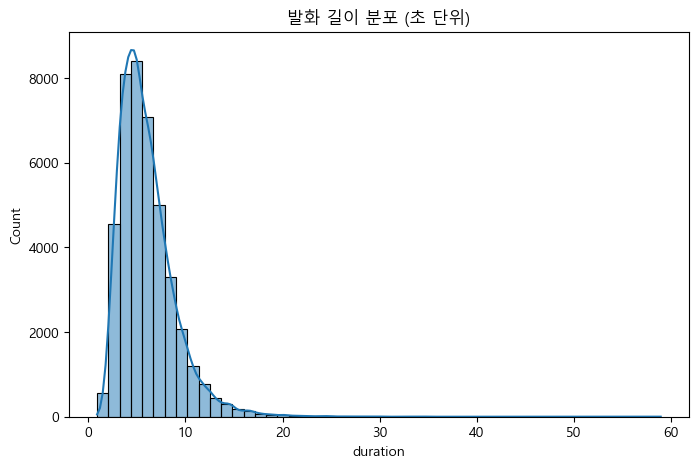

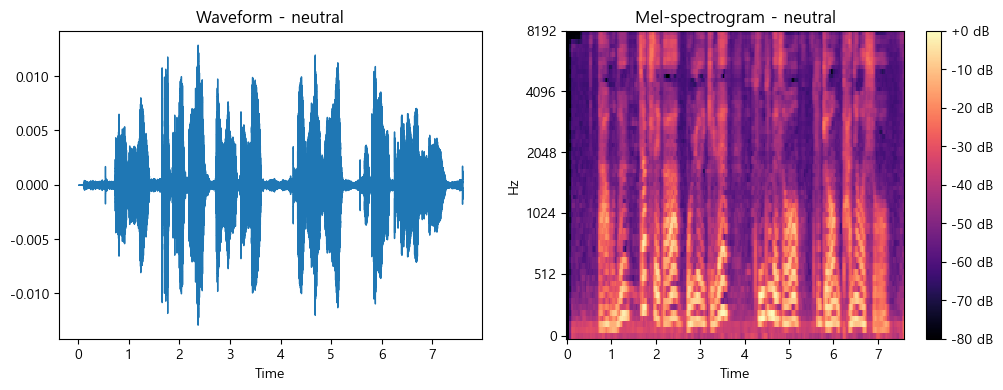

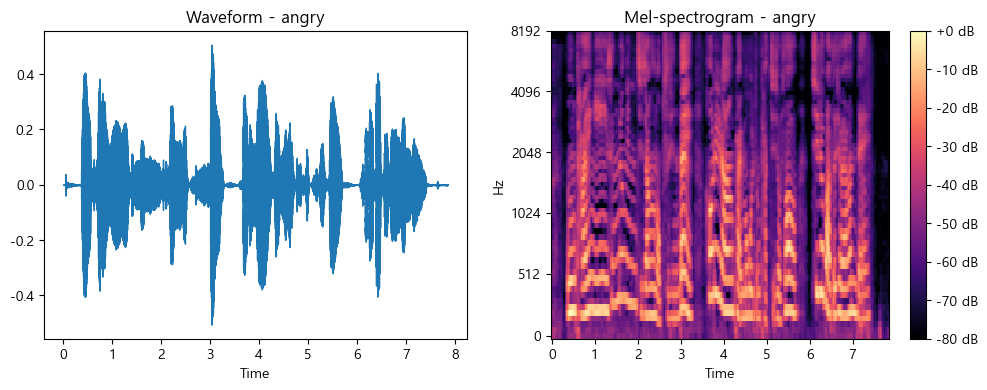

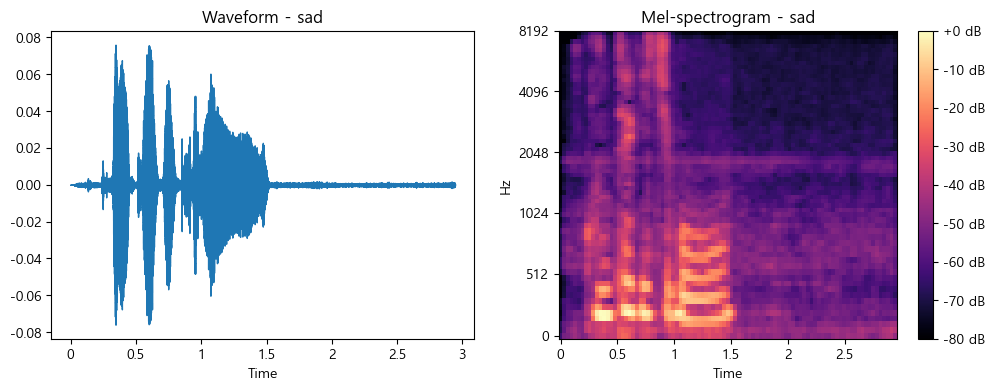

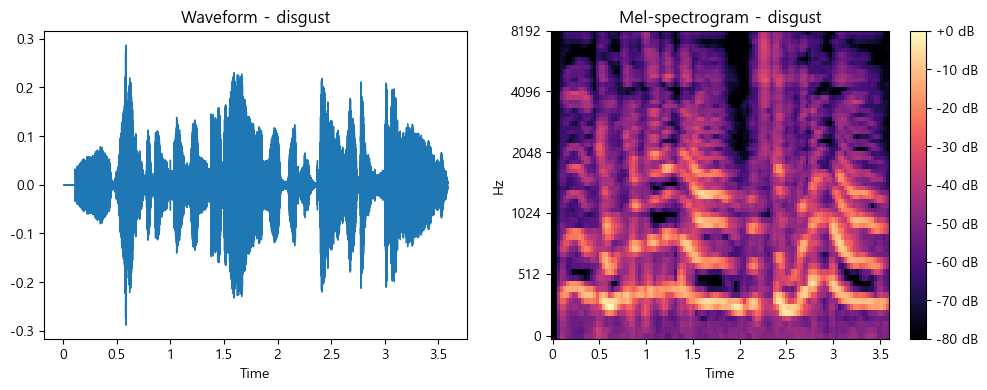

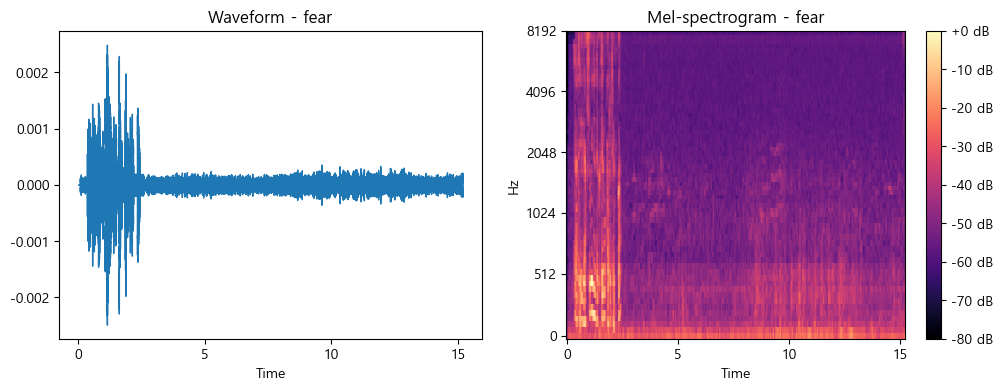

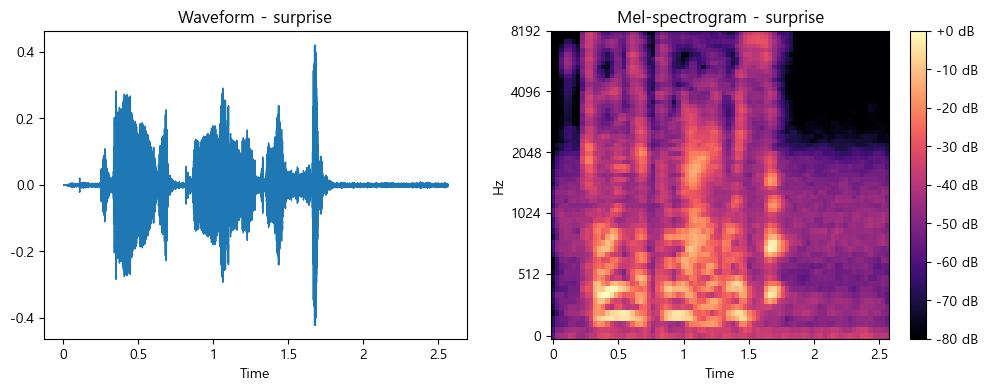

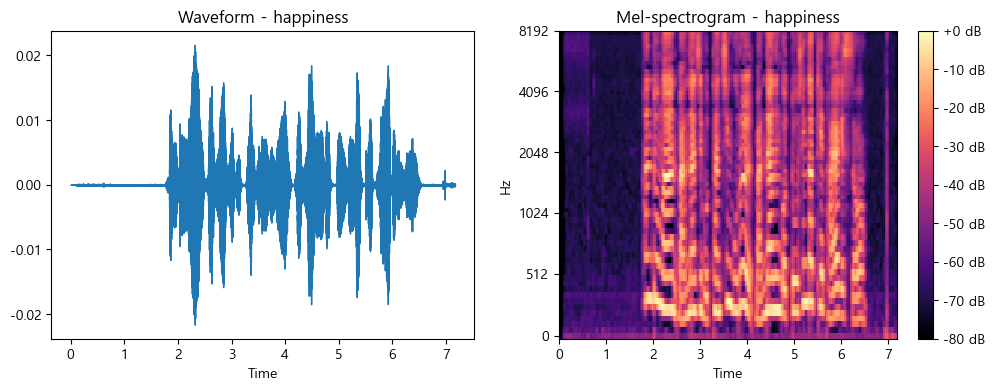

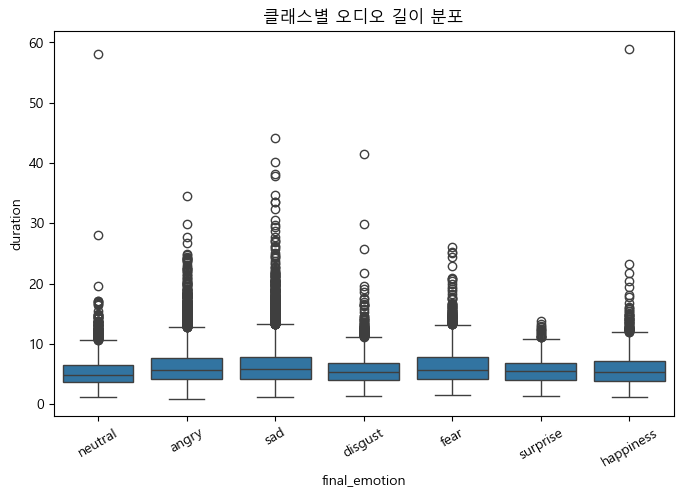

⚠️ agreement_ratio 낮은 샘플 예시:
                          wav_id final_emotion  agreement_ratio
29030  5f6892ebd338b948c4e68379     happiness              0.4
39441  5fb8c952cb503578af9edced       disgust              0.4
27697  5f617c663bd6941613f6d534       neutral              0.4
30945  5f7079f9111dfd48d40fd38e         angry              0.4
2632   5e3559eb5807b852d9e081eb         angry              0.4
🔍 Neutral/Surprise/Fear 샘플 예시:
                          wav_id final_emotion  agreement_ratio
37083  5fb33e4ee3dcec421f8357d7       neutral              1.0
37037  5fba1871cb503578af9ee05d       neutral              0.6
37867  5fb4d45c4c55eb78bd7cdb06       neutral              0.8
23778  5efabba78bbcd61f551d2bd9          fear              0.8
30720  5f6f371cd338b948c4e68954          fear              0.8


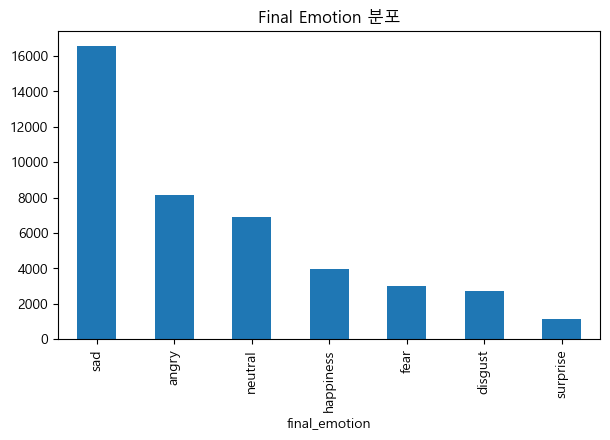

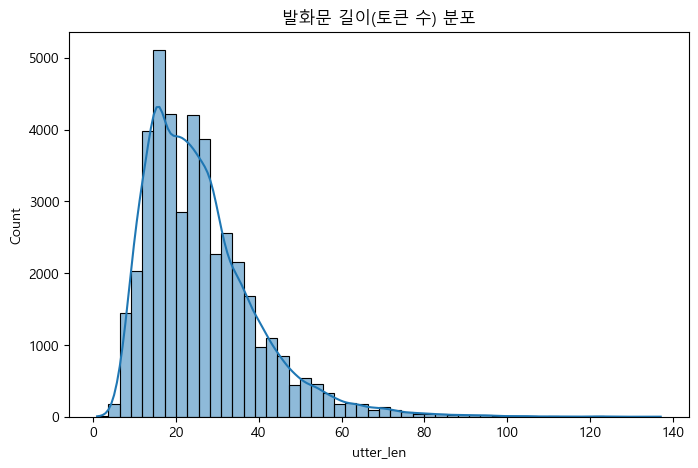

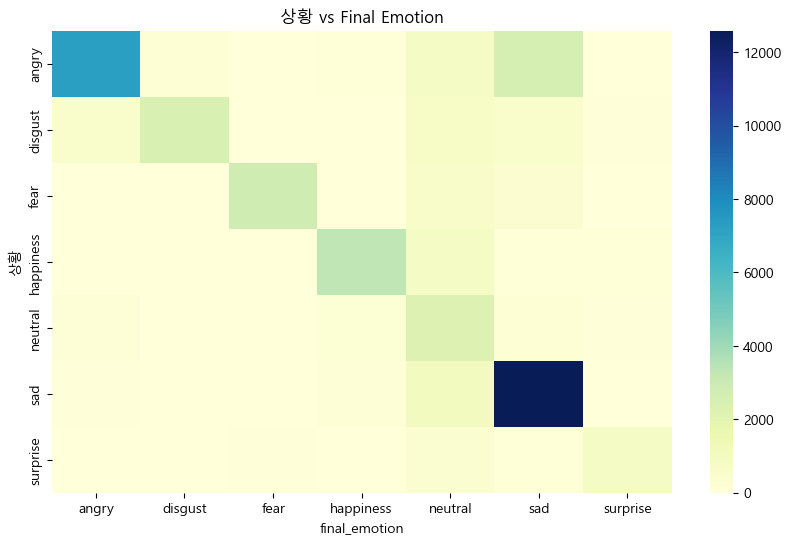

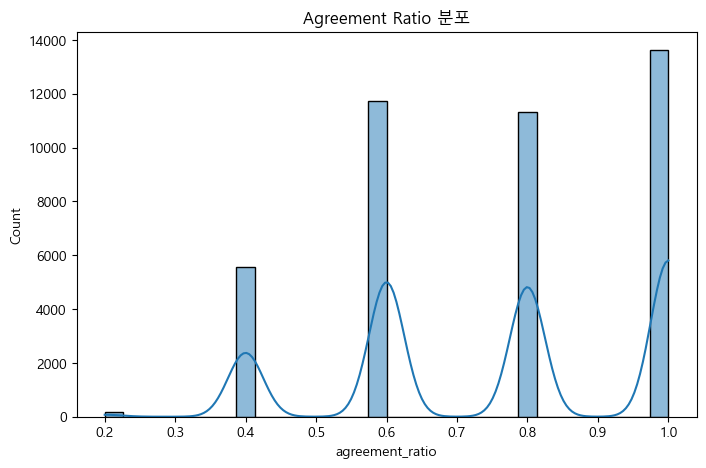

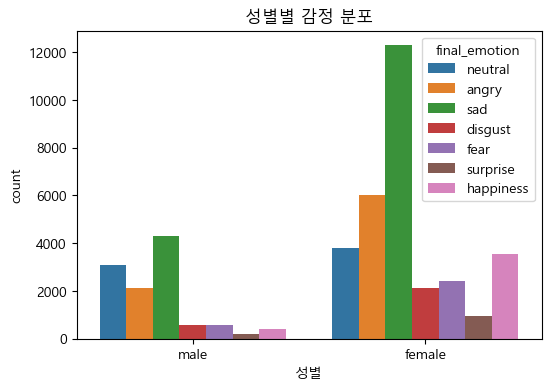

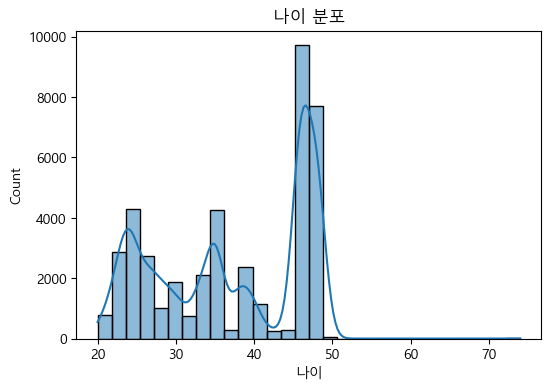

In [35]:
import os
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ====================================================
# A. 샘플 수준 확인
# ====================================================

# 1) 클래스별 오디오 샘플 2~3개 확인
def play_random_samples(df, n=2):
    samples = {}
    for emo in df["final_emotion"].unique():
        subset = df[df["final_emotion"] == emo]
        if len(subset) > 0:
            samples[emo] = subset.sample(min(n, len(subset)))["wav_path"].tolist()
    return samples

sample_paths = play_random_samples(clean_df, n=200)
print("🎧 랜덤 샘플 경로:\n", sample_paths)
# -> 여기서 실제 청취는 주피터/콜랩 환경에서 IPython.display.Audio 사용 가능

# 2) 발화 길이 분포 (duration)
plt.figure(figsize=(8,5))
sns.histplot(clean_df["duration"], bins=50, kde=True)
plt.title("발화 길이 분포 (초 단위)")
plt.show()

# ====================================================
# B. 시각적 확인
# ====================================================

# 클래스별 waveplot & mel-spectrogram 시각화
def plot_wave_mel(df, emotion):
    row = df[df["final_emotion"] == emotion].sample(1).iloc[0]
    y, sr = librosa.load(row["wav_path"], sr=16000)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform - {emotion}")
    
    plt.subplot(1,2,2)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.title(f"Mel-spectrogram - {emotion}")
    plt.colorbar(format="%+2.f dB")
    plt.show()

for emo in clean_df["final_emotion"].unique():
    plot_wave_mel(clean_df, emo)

# 클래스별 평균 duration 분포
plt.figure(figsize=(8,5))
sns.boxplot(x="final_emotion", y="duration", data=clean_df)
plt.title("클래스별 오디오 길이 분포")
plt.xticks(rotation=30)
plt.show()

# ====================================================
# C. 라벨 품질 점검
# ====================================================

# agreement_ratio 낮은 샘플 확인
low_agree = clean_df[clean_df["agreement_ratio"] < 0.6].sample(5)
print("⚠️ agreement_ratio 낮은 샘플 예시:\n", low_agree[["wav_id", "final_emotion", "agreement_ratio"]])

# confusion 높은 감정쌍 (neutral vs surprise, fear)
check_pairs = clean_df[clean_df["final_emotion"].isin(["neutral","surprise","fear"])]
print("🔍 Neutral/Surprise/Fear 샘플 예시:\n", check_pairs.sample(5)[["wav_id","final_emotion","agreement_ratio"]])

# ====================================================
# 추가 EDA (정량)
# ====================================================

# 1. final_emotion 분포
plt.figure(figsize=(7,4))
clean_df["final_emotion"].value_counts().plot(kind="bar")
plt.title("Final Emotion 분포")
plt.show()

# 2. utter_len (텍스트 길이) 분포
plt.figure(figsize=(8,5))
sns.histplot(clean_df["utter_len"], bins=50, kde=True)
plt.title("발화문 길이(토큰 수) 분포")
plt.show()

# 3. 상황 vs final_emotion 교차표
cross = pd.crosstab(clean_df["상황"], clean_df["final_emotion"])
plt.figure(figsize=(10,6))
sns.heatmap(cross, annot=False, cmap="YlGnBu")
plt.title("상황 vs Final Emotion")
plt.show()

# 4. agreement_ratio 전체 분포
plt.figure(figsize=(8,5))
sns.histplot(clean_df["agreement_ratio"], bins=30, kde=True)
plt.title("Agreement Ratio 분포")
plt.show()

# 5. 성별 편향
plt.figure(figsize=(6,4))
sns.countplot(x="성별", hue="final_emotion", data=clean_df)
plt.title("성별별 감정 분포")
plt.show()

# 6. 나이 분포
plt.figure(figsize=(6,4))
sns.histplot(clean_df["나이"], bins=30, kde=True)
plt.title("나이 분포")
plt.show()


In [37]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from itertools import chain

EMO_ORDER = ["angry","disgust","fear","happiness","neutral","sad","surprise"]  # 원하는 순서

def pick_paths_by_class(df, per_class=50, path_col="wav_path", label_col="final_emotion"):
    """감정별로 최대 per_class개의 wav 경로를 반환: dict[emotion] = [paths...]"""
    out = {}
    for emo in df[label_col].dropna().unique():
        sub = df[df[label_col] == emo]
        if len(sub) == 0: 
            continue
        # 존재하는 파일만
        paths = [p for p in sub.sample(min(per_class, len(sub)))[path_col].tolist() if os.path.exists(p)]
        if paths:
            out[emo] = paths
    return out

def flatten_paths(d_emotion_to_paths):
    """dict[emo]=[paths] -> flat list"""
    return list(chain.from_iterable(d_emotion_to_paths.values()))


In [38]:
def compute_melspec_power(path, sr=16000, n_mels=128):
    y, _ = librosa.load(path, sr=sr)
    # power=2.0 으로 선형 스케일 스펙트럼
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, power=2.0)
    return S  # (n_mels, T), power domain

def stack_time_aligned(mels_list, fixed_T=None, mode="truncate"):
    """
    mels_list: list of (n_mels, T_i) arrays (power domain)
    fixed_T: None이면 최소 길이로 자동
    mode: 'truncate' | 'pad'  (pad는 뒤쪽 0-패딩)
    """
    if not mels_list:
        return None
    if fixed_T is None:
        fixed_T = min(M.shape[1] for M in mels_list)
    aligned = []
    for M in mels_list:
        if M.shape[1] >= fixed_T:
            aligned.append(M[:, :fixed_T])
        else:
            if mode == "pad":
                pad = np.zeros((M.shape[0], fixed_T - M.shape[1]), dtype=M.dtype)
                aligned.append(np.concatenate([M, pad], axis=1))
            else:
                aligned.append(M)  # truncate 모드라면 여기선 고정 길이 보장 위해 pass하지 말고 pad 권장
    # truncate 모드에서는 고정 길이 보장을 위해 다시 슬라이스
    if mode != "pad":
        aligned = [A[:, :fixed_T] for A in aligned]
    return np.stack(aligned, axis=0)  # (N, n_mels, fixed_T)

def mean_std_from_paths(paths, sr=16000, n_mels=128, fixed_T=None, mode="truncate"):
    """여러 wav 경로 → 평균/표준편차 멜스펙(dB)"""
    mels = []
    for p in paths:
        try:
            M = compute_melspec_power(p, sr=sr, n_mels=n_mels)
            mels.append(M)
        except Exception as e:
            # 손상/부재 파일은 스킵
            continue
    stk = stack_time_aligned(mels, fixed_T=fixed_T, mode=mode)
    if stk is None:
        return None, None
    mean_power = stk.mean(axis=0)          # (n_mels, T)
    std_power  = stk.std(axis=0) + 1e-12   # 0 회피용 eps
    # 시각화는 dB로
    mean_db = librosa.power_to_db(mean_power, ref=np.max)
    # 분산 자체를 dB로 변환하진 않음. 시각화 편의상 표준편차를 그대로 log처럼 보려면 정규화 가능
    std_db_vis = librosa.power_to_db(std_power / std_power.max(), ref=1.0)  # 0~1 정규화 후 dB 변환 (보기용)
    return mean_db, std_db_vis


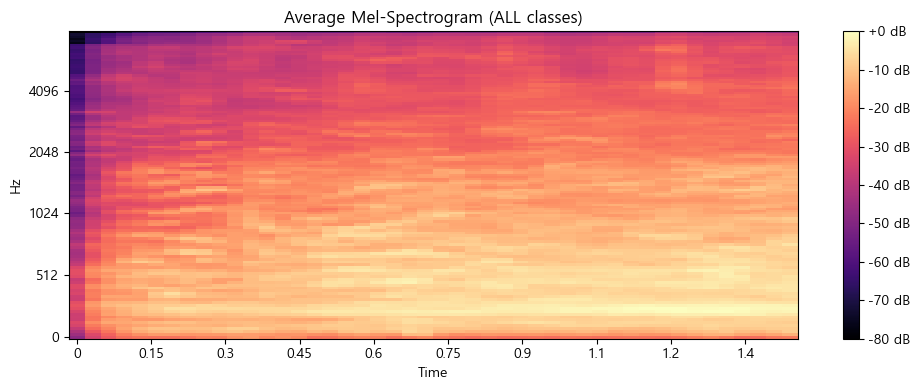

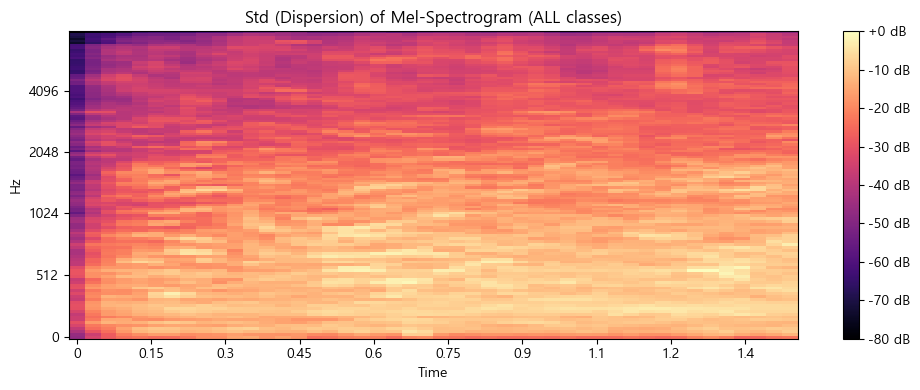

In [39]:
# 예) 감정별로 최대 200개씩 뽑은 다음 전체를 플랫으로 합치기
emo_to_paths = pick_paths_by_class(clean_df, per_class=200, path_col="wav_path", label_col="final_emotion")
all_paths = flatten_paths(emo_to_paths)

mean_db_all, std_db_all = mean_std_from_paths(all_paths, sr=16000, n_mels=128, fixed_T=None, mode="truncate")

if mean_db_all is not None:
    plt.figure(figsize=(10,4))
    librosa.display.specshow(mean_db_all, sr=16000, x_axis='time', y_axis='mel')
    plt.title("Average Mel-Spectrogram (ALL classes)")
    plt.colorbar(format="%+2.f dB"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,4))
    librosa.display.specshow(std_db_all, sr=16000, x_axis='time', y_axis='mel')
    plt.title("Std (Dispersion) of Mel-Spectrogram (ALL classes)")
    plt.colorbar(format="%+2.f dB"); plt.tight_layout(); plt.show()


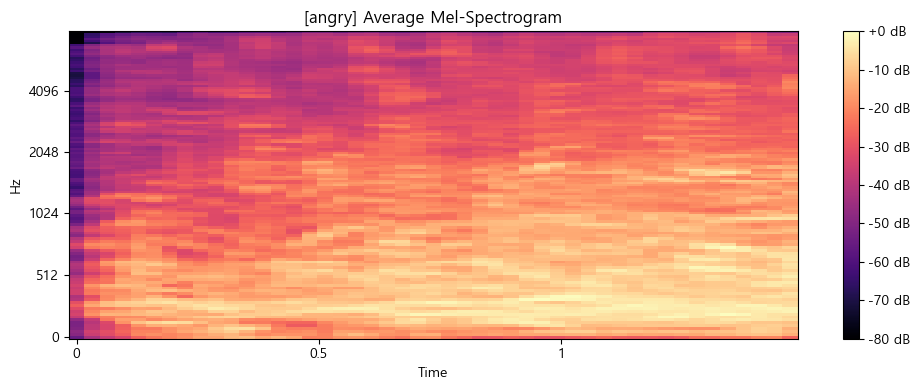

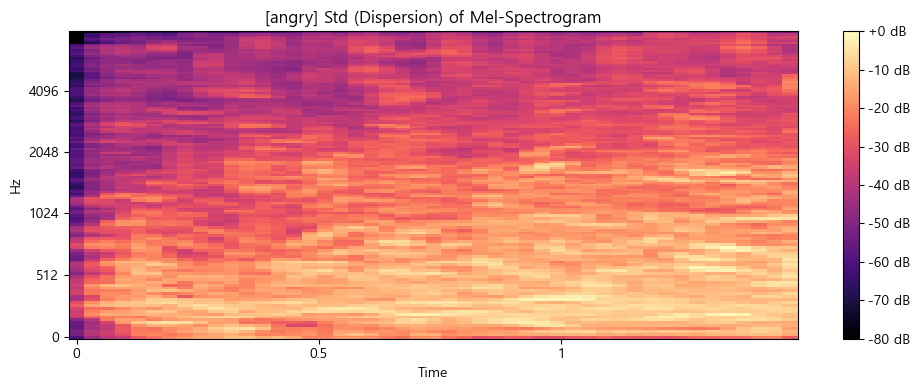

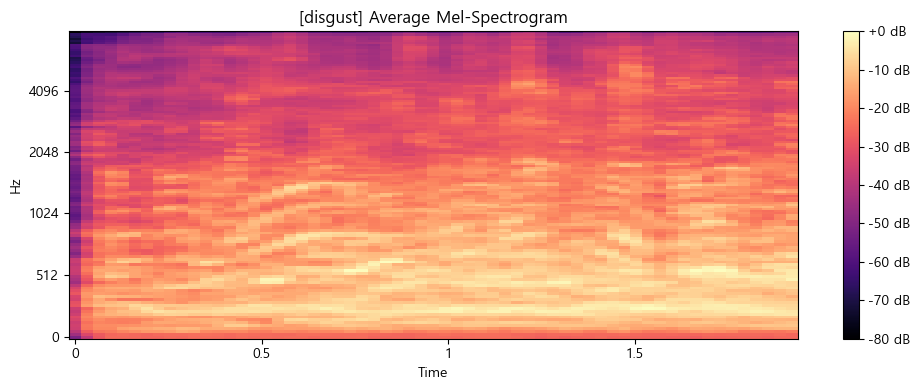

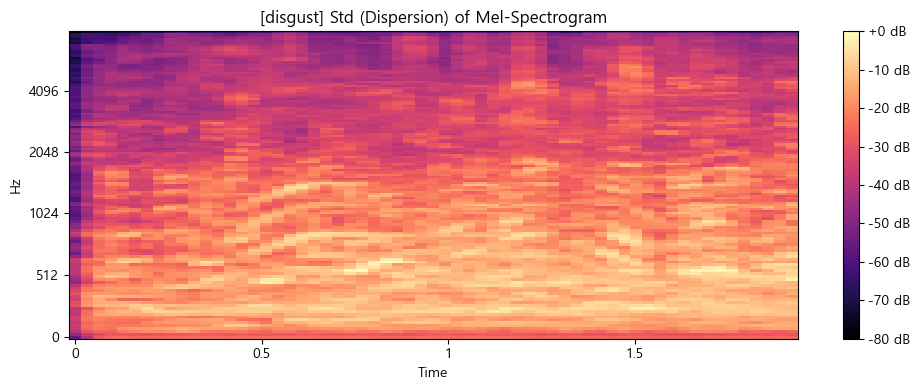

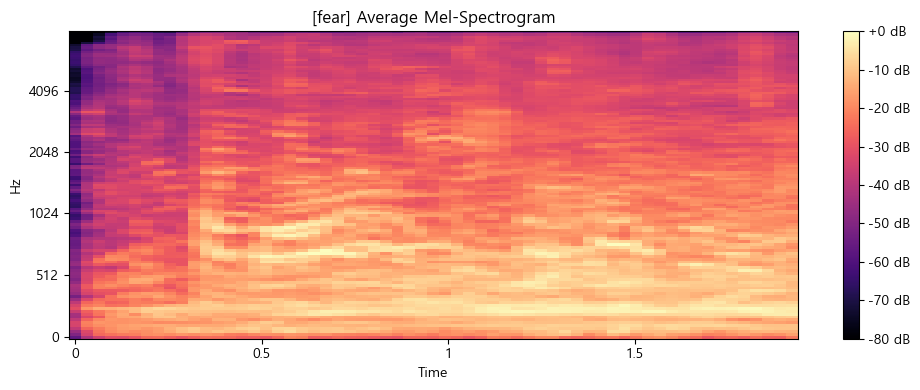

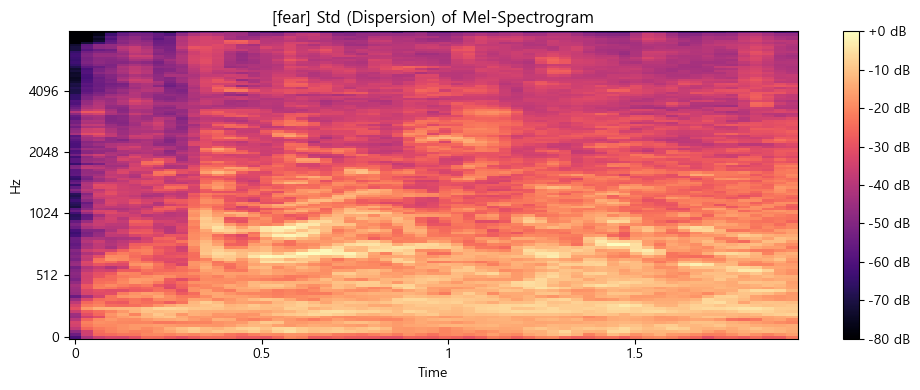

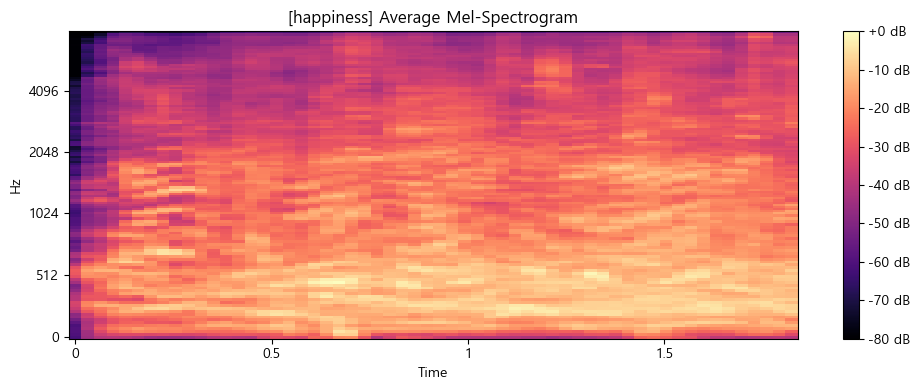

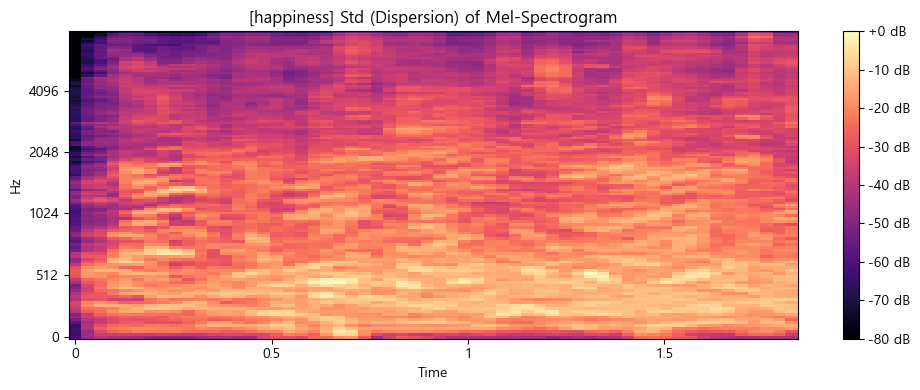

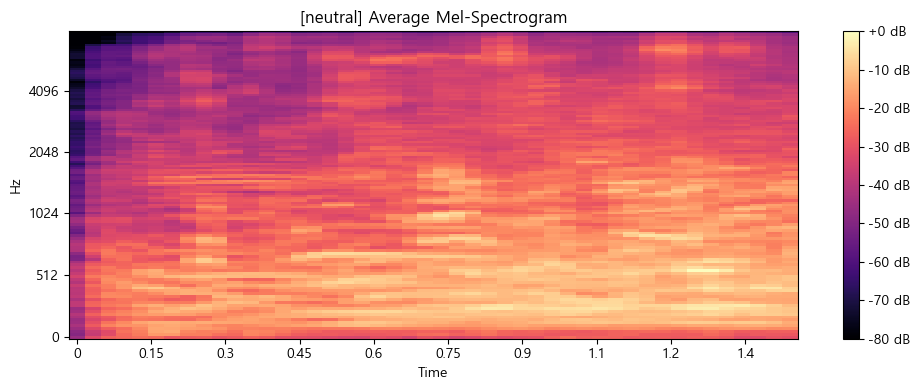

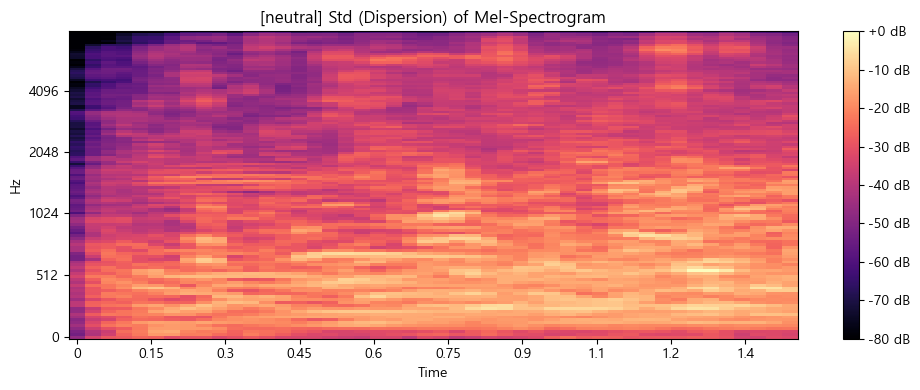

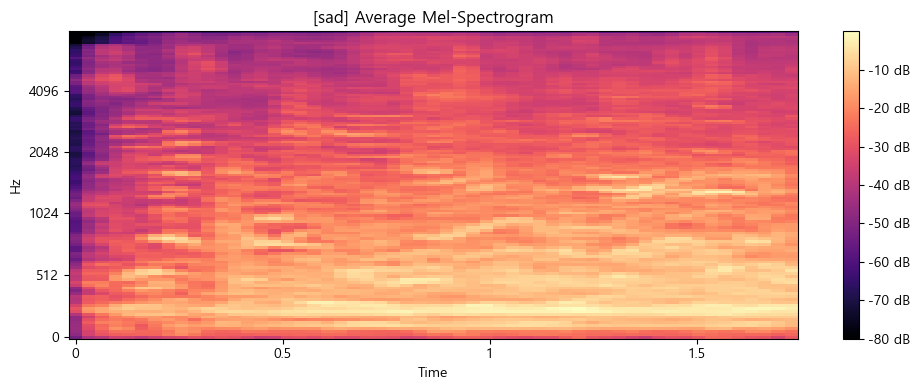

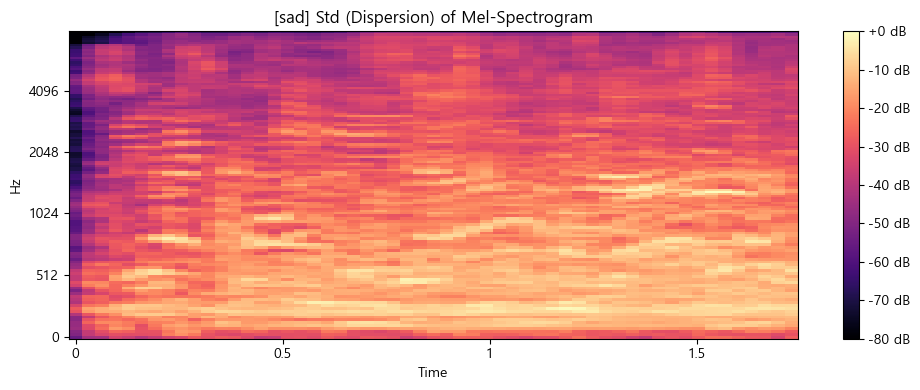

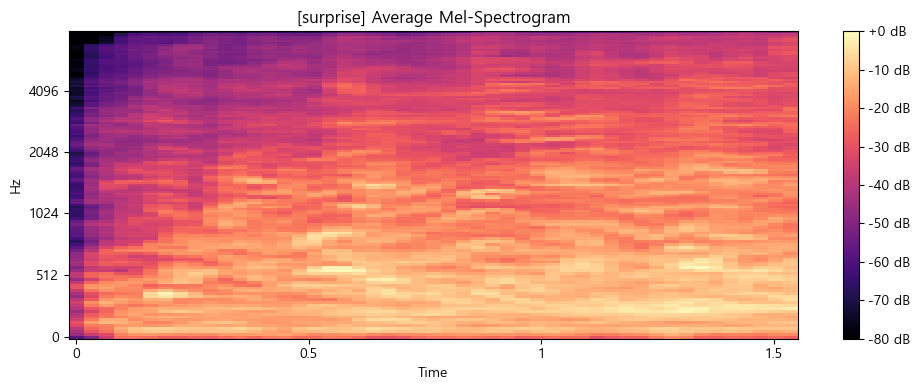

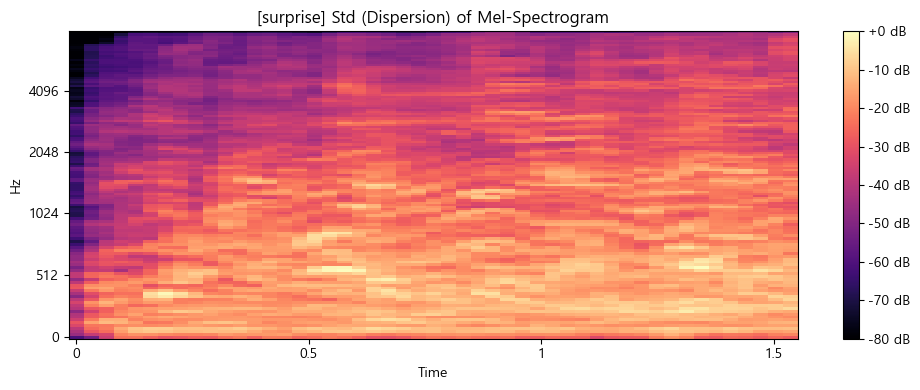

In [40]:
for emo in (EMO_ORDER if set(EMO_ORDER) <= set(emo_to_paths.keys()) else emo_to_paths.keys()):
    paths = emo_to_paths.get(emo, [])
    if not paths:
        continue
    mean_db, std_db = mean_std_from_paths(paths, sr=16000, n_mels=128, fixed_T=None, mode="truncate")
    if mean_db is None:
        continue

    plt.figure(figsize=(10,4))
    librosa.display.specshow(mean_db, sr=16000, x_axis='time', y_axis='mel')
    plt.title(f"[{emo}] Average Mel-Spectrogram")
    plt.colorbar(format="%+2.f dB"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,4))
    librosa.display.specshow(std_db, sr=16000, x_axis='time', y_axis='mel')
    plt.title(f"[{emo}] Std (Dispersion) of Mel-Spectrogram")
    plt.colorbar(format="%+2.f dB"); plt.tight_layout(); plt.show()


In [32]:
import os, numpy as np, pandas as pd
import librosa, librosa.feature, librosa.util

def compute_quality(y, sr):
    y = librosa.util.normalize(y, axis=0)  # 레벨 표준화(peak=1 기준 아님, 스케일 안정용)
    peak = float(np.max(np.abs(y)) + 1e-12)
    rms = float(np.sqrt(np.mean(y**2)) + 1e-12)
    crest = float(peak / rms)

    # clipping: 정규화 이후에도 ±0.99 근처면 포화 가능성
    clipping_ratio = float(np.mean(np.abs(y) >= 0.99))

    # DC offset
    dc_offset = float(np.mean(y))

    # 프레임 RMS로 무음 비율
    hop = int(0.010 * sr)  # 10ms
    frm = int(0.025 * sr)  # 25ms
    frame_rms = librosa.feature.rms(y=y, frame_length=frm, hop_length=hop)[0]
    thr = np.percentile(frame_rms, 20)  # 하위 20%를 저에너지 기준으로
    silence_ratio = float(np.mean(frame_rms < max(thr, 1e-6)))

    # 간이 SNR: 앞뒤 0.3초를 noise, 중앙 0.6초를 speech로 가정
    n_edge = int(0.3 * sr)
    if len(y) > 2 * n_edge:
        noise = np.concatenate([y[:n_edge], y[-n_edge:]])
        mid = y[n_edge:-n_edge]
    else:
        # 길이가 짧으면 하위 20% vs 상위 80% 프레임으로 근사
        idx = frame_rms.argsort()
        k = max(1, int(0.2 * len(idx)))
        noise = librosa.util.frame(y, frame_length=frm, hop_length=hop).T[idx[:k]].ravel()
        mid   = librosa.util.frame(y, frame_length=frm, hop_length=hop).T[idx[k:]].ravel()
    nrms = float(np.sqrt(np.mean(noise**2)) + 1e-12)
    srms = float(np.sqrt(np.mean(mid**2)) + 1e-12)
    snr_proxy_db = float(10 * np.log10((srms**2) / (nrms**2)))

    # 스펙트럼 기반
    S = np.abs(librosa.stft(y, n_fft=1024, hop_length=hop))**2
    mel = librosa.feature.melspectrogram(S=S, sr=sr, n_mels=64, power=1.0)
    mel_norm = mel / (mel.sum(axis=0, keepdims=True) + 1e-12)

    # 고주파 비율(>6kHz)
    mel_f = librosa.mel_frequencies(n_mels=64, fmin=0, fmax=sr/2)
    hf_mask = mel_f >= 6000
    hf_ratio = float((mel_norm[hf_mask, :].sum()) / (mel_norm.sum() + 1e-12))

    # 스펙트럴 중심/대역폭(평균)
    centroid = librosa.feature.spectral_centroid(S=S, sr=sr)[0]
    bandwidth = librosa.feature.spectral_bandwidth(S=S, sr=sr)[0]
    centroid_mean = float(np.mean(centroid))
    bandwidth_mean = float(np.mean(bandwidth))

    return dict(
        peak=peak, rms=rms, crest=crest, clipping_ratio=clipping_ratio, dc_offset=dc_offset,
        silence_ratio=silence_ratio, snr_proxy_db=snr_proxy_db, hf_ratio=hf_ratio,
        centroid_mean=centroid_mean, bandwidth_mean=bandwidth_mean
    )

def quality_for_paths(paths, sr=16000, max_files=None):
    rows = []
    for i, p in enumerate(paths):
        if (max_files is not None) and (i >= max_files): break
        if not os.path.exists(p): continue
        try:
            y, _ = librosa.load(p, sr=sr)
            q = compute_quality(y, sr)
            q["wav_path"] = p
            rows.append(q)
        except Exception:
            continue
    return pd.DataFrame(rows)


In [ ]:
# 감정별로 균형 샘플 추출 (이미 clean_df에 wav_path, final_emotion 가정)
per_class = 50
emo2paths = {emo: grp["wav_path"].sample(min(per_class, len(grp))).tolist()
             for emo, grp in clean_df.groupby("final_emotion")}

# 합치기
scan_paths = [p for paths in emo2paths.values() for p in paths]
qdf = quality_for_paths(scan_paths, sr=16000)

# 감정 라벨 붙이기
emap = clean_df.set_index("wav_path")["final_emotion"].to_dict()
qdf["final_emotion"] = qdf["wav_path"].map(emap)

# 클래스별 중앙값/분위수 요약
summary = qdf.groupby("final_emotion").agg(
    n=("wav_path","count"),
    rms_med=("rms","median"),
    crest_med=("crest","median"),
    clip95=("clipping_ratio", lambda x: np.percentile(x,95)),
    dc_med=("dc_offset","median"),
    sil_med=("silence_ratio","median"),
    snr_med=("snr_proxy_db","median"),
    hf_med=("hf_ratio","median"),
).sort_values("n", ascending=False)
print(summary)


                n   rms_med  crest_med    clip95        dc_med   sil_med  \
final_emotion                                                              
angry          50  0.114388   8.742251  0.000038 -2.446472e-07  0.200264   
disgust        50  0.118949   8.407085  0.000036 -8.828809e-06  0.200355   
fear           50  0.124719   8.018072  0.000053 -5.359694e-06  0.200355   
happiness      50  0.118892   8.412872  0.000039 -8.678160e-06  0.200284   
neutral        50  0.097399  10.267085  0.000053 -1.729497e-05  0.200397   
sad            50  0.109997   9.091225  0.000034 -3.656144e-06  0.200370   
surprise       50  0.125456   7.971453  0.000077 -1.378907e-05  0.200349   

                 snr_med    hf_med  
final_emotion                       
angry          23.661125  0.009182  
disgust        21.528900  0.007543  
fear           22.922326  0.008310  
happiness      24.157196  0.014135  
neutral        24.094717  0.007599  
sad            19.840162  0.006993  
surprise       24.3

In [34]:
# 간단 임계값(경험칙): 필요에 따라 조정
CLIP_T = 0.01      # 1% 이상 포화
CREST_T = 20.0     # 과도한 크레스트(연기톤/과장 가능)
DC_T = 0.02        # DC 오프셋
SIL_T = 0.6        # 무음 과다
SNR_T = 5.0        # SNR 낮음(근사치)

flags = (
    (qdf["clipping_ratio"] > CLIP_T) |
    (qdf["crest"] > CREST_T) |
    (np.abs(qdf["dc_offset"]) > DC_T) |
    (qdf["silence_ratio"] > SIL_T) |
    (qdf["snr_proxy_db"] < SNR_T)
)
bad = qdf[flags].sort_values(["clipping_ratio","crest","silence_ratio"], ascending=False)
print("⚠️ 품질 플래그 샘플 상위 20개")
cols = ["final_emotion","wav_path","clipping_ratio","crest","snr_proxy_db","silence_ratio","dc_offset","hf_ratio"]
print(bad[cols].head(20))


⚠️ 품질 플래그 샘플 상위 20개
    final_emotion                                           wav_path  \
305      surprise  D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...   
273           sad  D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...   
101          fear  D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...   
219       neutral  D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...   
214       neutral  D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...   
291           sad  D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...   
327      surprise  D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...   
128          fear  D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...   
182     happiness  D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...   
94        disgust  D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...   
308      surprise  D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...   
54        disgust  D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...   
178     happiness  D:\ex\최종프로젝트\AI_Dev_3rd_P

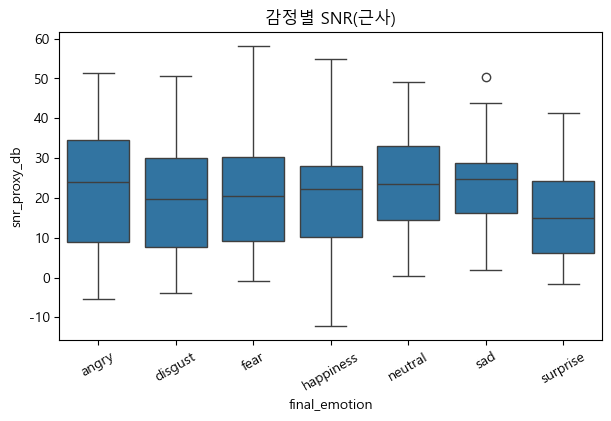

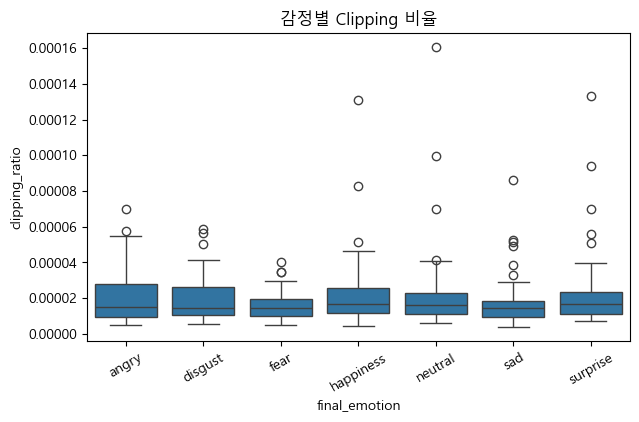

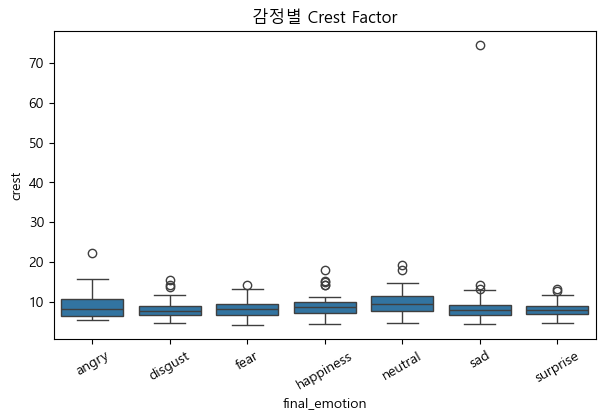

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4))
sns.boxplot(x="final_emotion", y="snr_proxy_db", data=qdf)
plt.title("감정별 SNR(근사)"); plt.xticks(rotation=30); plt.show()

plt.figure(figsize=(7,4))
sns.boxplot(x="final_emotion", y="clipping_ratio", data=qdf)
plt.title("감정별 Clipping 비율"); plt.xticks(rotation=30); plt.show()

plt.figure(figsize=(7,4))
sns.boxplot(x="final_emotion", y="crest", data=qdf)
plt.title("감정별 Crest Factor"); plt.xticks(rotation=30); plt.show()


In [23]:
clean_df['wav_path']

0        D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...
1        D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...
2        D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...
3        D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...
4        D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...
                               ...                        
43986    D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...
43987    D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...
43988    D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...
43989    D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...
43990    D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감...
Name: wav_path, Length: 42424, dtype: object

In [24]:
from pathlib import Path

# 경로 존재 여부 점검
paths = clean_df["wav_path"].astype(str).tolist()
exists_mask = [Path(p).exists() for p in paths]
print("존재:", sum(exists_mask), " / 누락:", len(paths) - sum(exists_mask))

# 누락 예시 5개 확인
missing = [p for p, ok in zip(paths, exists_mask) if not ok]
print("누락 예시:", missing[:5])


존재: 42408  / 누락: 16
누락 예시: ['D:\\ex\\최종프로젝트\\AI_Dev_3rd_Project\\YEO\\datasets\\감정분류대화음성\\감정 분류를 위한 대화 음성 데이터셋\\4차\\5e2979c25807b852d9e018d5.wav', 'D:\\ex\\최종프로젝트\\AI_Dev_3rd_Project\\YEO\\datasets\\감정분류대화음성\\감정 분류를 위한 대화 음성 데이터셋\\4차\\5e298b9f5807b852d9e01a0f.wav', 'D:\\ex\\최종프로젝트\\AI_Dev_3rd_Project\\YEO\\datasets\\감정분류대화음성\\감정 분류를 위한 대화 음성 데이터셋\\4차\\5e298bc45807b852d9e01a10.wav', 'D:\\ex\\최종프로젝트\\AI_Dev_3rd_Project\\YEO\\datasets\\감정분류대화음성\\감정 분류를 위한 대화 음성 데이터셋\\4차\\5e298bdc5807b852d9e01a11.wav', 'D:\\ex\\최종프로젝트\\AI_Dev_3rd_Project\\YEO\\datasets\\감정분류대화음성\\감정 분류를 위한 대화 음성 데이터셋\\4차\\5e298c085807b852d9e01a12.wav']


In [25]:
from pathlib import Path

# wav_path 존재 여부 확인
clean_df["exists"] = clean_df["wav_path"].apply(lambda p: Path(str(p)).exists())

# 누락된 개수 확인
print("누락된 샘플 수:", (~clean_df["exists"]).sum())

# 없는 파일 드롭 → 최종 데이터셋
final_df = clean_df[clean_df["exists"]].copy().reset_index(drop=True)

print("드롭 후 데이터셋 크기:", len(final_df))

누락된 샘플 수: 16
드롭 후 데이터셋 크기: 42408


In [26]:
final_df.to_csv("clean_df_final.csv", index=False, encoding="utf-8-sig")

In [28]:
import torchaudio
# SR 분포 확인
sr_counts = final_df["wav_path"].apply(lambda p: torchaudio.info(p).sample_rate).value_counts()
print(sr_counts)

# 리샘플러 예시(가짜 코드; 실제는 Dataset __getitem__에서 적용)
resampler = torchaudio.transforms.Resample(orig_freq=orig_sr, new_freq=16000)  # soxr 있으면 soxr_vhq 권장
y16k = resampler(y)  # mono 변환도 함께 수행

wav_path
48000    42408
Name: count, dtype: int64


NameError: name 'orig_sr' is not defined

In [29]:
import torchaudio

# 예시: 파일 하나 로드 + 리샘플
wav_path = final_df.iloc[0]["wav_path"]
y, sr = torchaudio.load(wav_path)   # sr == 48000
resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
y16k = resampler(y)  # shape: [channels, T']

print("before:", sr, "after:", 16000, "length:", y.shape[-1], "->", y16k.shape[-1])


before: 48000 after: 16000 length: 157696 -> 52566


In [44]:
import torchaudio
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

def compute_quality(path, target_sr=16000):
    try:
        # 로드
        y, sr = torchaudio.load(path)
        if y.shape[0] > 1:
            y = torch.mean(y, dim=0, keepdim=True)
        y = y.squeeze().numpy()

        # 리샘플 필요시
        if sr != target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

        # duration
        duration = len(y) / target_sr

        # RMS, Crest factor
        rms = np.sqrt(np.mean(y**2)) + 1e-8
        peak = np.max(np.abs(y))
        crest = peak / rms if rms > 0 else 0

        # clipping ratio (임계치 0.99 이상)
        clip_ratio = np.mean(np.abs(y) >= 0.99)

        # DC offset
        dc_offset = np.mean(y)

        # Silence ratio (샘플 중 절대값 <0.001)
        silence_ratio = np.mean(np.abs(y) < 1e-3)

        # 근사 SNR: RMS / 배경 노이즈(하위 10% 절댓값)
        noise_floor = np.percentile(np.abs(y), 10)
        snr_proxy = 20 * np.log10(rms / (noise_floor + 1e-8))

        # High-frequency ratio (단순 스펙트럼 분포 기반)
        S = np.abs(librosa.stft(y, n_fft=512, hop_length=256))
        freqs = librosa.fft_frequencies(sr=target_sr, n_fft=512)
        hf_ratio = np.sum(S[freqs > 4000]) / np.sum(S)

        return {
            "wav_path": str(path),
            "duration": duration,
            "rms": rms,
            "crest": crest,
            "clipping_ratio": clip_ratio,
            "dc_offset": dc_offset,
            "silence_ratio": silence_ratio,
            "snr_proxy_db": snr_proxy,
            "hf_ratio": hf_ratio,
        }
    except Exception as e:
        return None

# ---- 전체 데이터셋에 적용 ----
paths = final_df["wav_path"].tolist()
records = []

for p in tqdm(paths, desc="Computing quality metrics", unit="file"):
    q = compute_quality(p, target_sr=16000)
    if q is not None:
        records.append(q)

qdf = pd.DataFrame(records)
print("완료! qdf 크기:", len(qdf))


Computing quality metrics: 100%|██████████| 42408/42408 [08:24<00:00, 84.03file/s] 


완료! qdf 크기: 42408


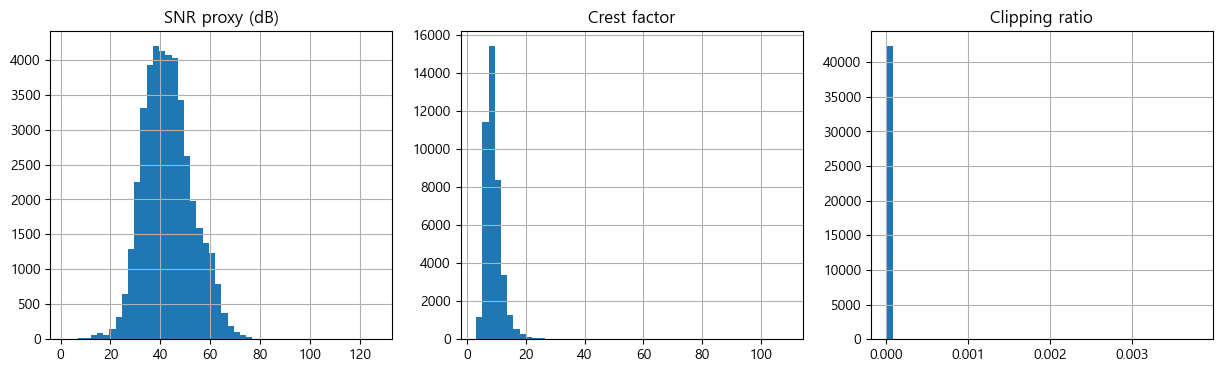

In [45]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15,4))

qdf["snr_proxy_db"].hist(bins=50, ax=axes[0])
axes[0].set_title("SNR proxy (dB)")

qdf["crest"].hist(bins=50, ax=axes[1])
axes[1].set_title("Crest factor")

qdf["clipping_ratio"].hist(bins=50, ax=axes[2])
axes[2].set_title("Clipping ratio")

plt.show()

In [49]:
clean_df.columns

Index(['wav_id', '발화문', '상황', '1번 감정', '1번 감정세기', '2번 감정', '2번 감정세기', '3번 감정',
       '3번 감정세기', '4번 감정', '4번 감정세기', '5번 감정', '5번 감정세기', '나이', '성별',
       'wav_path', 'wav_exists', 'duration', 'dataset_part', 'final_emotion',
       'tie_initial', 'tie_resolved_by_situation', 'utter_len',
       'agreement_ratio', 'agreement_count', 'voters_count', 'exists'],
      dtype='object')

In [51]:
final_df.columns

Index(['wav_id', '발화문', '상황', '1번 감정', '1번 감정세기', '2번 감정', '2번 감정세기', '3번 감정',
       '3번 감정세기', '4번 감정', '4번 감정세기', '5번 감정', '5번 감정세기', '나이', '성별',
       'wav_path', 'wav_exists', 'duration', 'dataset_part', 'final_emotion',
       'tie_initial', 'tie_resolved_by_situation', 'utter_len',
       'agreement_ratio', 'agreement_count', 'voters_count', 'exists'],
      dtype='object')

In [ ]:
# clean_df와 qdf merge (라벨 포함되도록!)
merged = final_df[["wav_path", "final_emotion", "agreement_ratio"]].merge(
    qdf[["wav_path","duration","snr_proxy_db","crest","clipping_ratio"]],
    on="wav_path", how="inner"
)


# 필터링 기준 (기본값)
mask_all = (
    (merged["agreement_ratio"] >= 0.6) &
    (merged["duration"] >= 0.2) &
    (merged["snr_proxy_db"] >= 10) &        # 완화: -inf~0 dB 제외
    (merged["crest"] <= 30) &              # 완화: 극단 outlier만 제외
    (merged["clipping_ratio"] <= 0.01)     # 완화: 5% 이상만 제외
)

filtered_df = merged[mask_all].copy()

print("원본:", len(final_df))
print("필터링 후:", len(filtered_df))
print("제외:", len(final_df)-len(filtered_df))

print("필터링 후 클래스 분포:")
print(filtered_df["final_emotion"].value_counts())


원본: 42408
필터링 후: 36500
제외: 5908
필터링 후 클래스 분포:
final_emotion
sad          15419
angry         6914
neutral       5438
happiness     3457
fear          2455
disgust       2091
surprise       726
Name: count, dtype: int64


In [41]:
merged.columns

Index(['wav_id', '발화문', '상황', '1번 감정', '1번 감정세기', '2번 감정', '2번 감정세기', '3번 감정',
       '3번 감정세기', '4번 감정', '4번 감정세기', '5번 감정', '5번 감정세기', '나이', '성별',
       'wav_path', 'wav_exists', 'duration', 'dataset_part', 'final_emotion_x',
       'tie_initial', 'tie_resolved_by_situation', 'utter_len',
       'agreement_ratio', 'agreement_count', 'voters_count', 'exists', 'peak',
       'rms', 'crest', 'clipping_ratio', 'dc_offset', 'silence_ratio',
       'snr_proxy_db', 'hf_ratio', 'centroid_mean', 'bandwidth_mean',
       'final_emotion_y'],
      dtype='object')